In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy import stats
import numpy as np
import csv
import json
sns.set(style="whitegrid")

### Comparison of word choice metrics

In [7]:
root = '/mnt/data0/lucy/ingroup_lang/'

In [3]:
count_cut_off = 0
pmi_cut_off = 5.940024063721074
tfidf_cut_off = 2
sensepmi_cut_off = 3.038046754473495

In [8]:
def metric_correlation(metric1, metric2, sr_f, path1, path2, plot=True): 
    df1 = pd.read_csv(path1 + sr_f, engine='python')
    df2 = pd.read_csv(path2 + sr_f, engine='python')
    df = pd.merge(df1, df2, on='word', how='outer')
    corr = stats.pearsonr(df[metric1], df[metric2])
    if plot: 
        print(corr)
        p = sns.scatterplot(x=metric1, y=metric2, data=df)
        plt.title(sr_f)
        plt.show()
    return corr
def metric_correlation_generic(metric1, metric2, path1, path2, join_on, title, ylog=False, ylim=None): 
    df1 = pd.read_csv(path1, engine='python')
    df2 = pd.read_csv(path2, engine='python')
    df = pd.merge(df1, df2, on=join_on, how='outer')
    p = sns.scatterplot(x=metric1, y=metric2, data=df)
    print(stats.pearsonr(df[metric1], df[metric2]))
    if ylog: 
        plt.yscale('log')
    if ylim: 
        plt.ylim(ylim)
    plt.title(title)
    plt.show()

(0.738676274604432, 0.0)


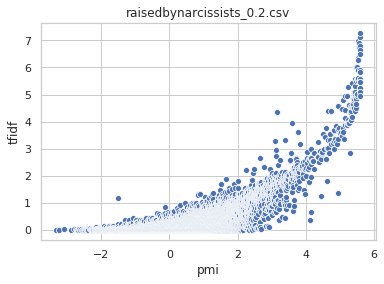

(0.738676274604432, 0.0)

In [9]:
metric_correlation('pmi', 'tfidf', 'raisedbynarcissists_0.2.csv', root + 'logs/pmi/', root + 'logs/tfidf/')

(0.6962358253738823, 0.0)


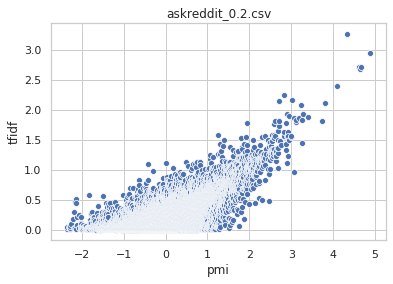

(0.6962358253738823, 0.0)

In [10]:
metric_correlation('pmi', 'tfidf', 'askreddit_0.2.csv', root + 'logs/pmi/', root + 'logs/tfidf/')

In [11]:
corrs = []
for sr in os.listdir(root + 'logs/pmi/'): 
    corr = metric_correlation('pmi', 'tfidf', sr, 
                              root + 'logs/pmi/', root + 'logs/tfidf/', plot=False)
    corrs.append(corr[0])
print(np.mean(corrs))
print(np.var(corrs))

0.8502173768878217
0.003438580350562592


### Comparison of user metrics

(0.21344521958285168, 2.7467224122880737e-06)


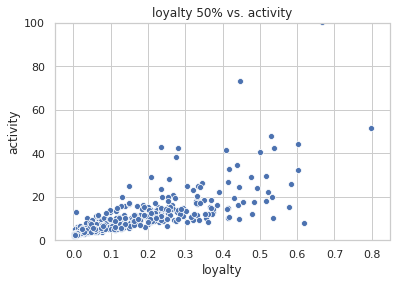

In [429]:
# for different thresholds, the pearson corr is still around 0.22
# however there are subreddits with similar levels of activity but different loyalty
threshold = 50
commentor_path1 = root + 'logs/commentor_loyalty_'+str(threshold)
commentor_path2 = root + 'logs/commentor_activity'
metric_correlation_generic('loyalty', 'activity', commentor_path1, commentor_path2, 
                           'subreddit', 'loyalty ' + str(threshold) + '% vs. activity', ylim=(0,100))

(0.47110993439816284, 1.4687530397471959e-27)


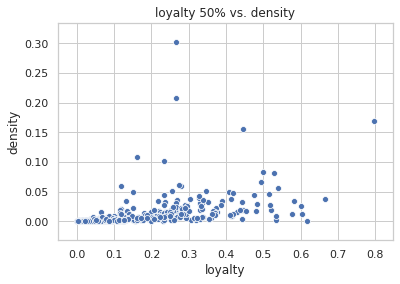

In [430]:
threshold = 50
commentor_path1 = root + 'logs/commentor_loyalty_'+str(threshold)
commentor_path2 = root + 'logs/commentor_density'
metric_correlation_generic('loyalty', 'density', commentor_path1, commentor_path2, 
                           'subreddit', 'loyalty ' + str(threshold) + '% vs. density')

### Word choice vs. word frequency

In [431]:
def metric_vs_frequency(metric_name, path, n): 
    # generate plot for 10 subreddits
    i = 0
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        df = pd.read_csv(path + f, engine='python')
        df = df[df['count'] > count_cut_off]
        p = sns.scatterplot(x='count', y=metric_name, data=df)
        p.figure.get_axes()[0].set_xscale('log')
        plt.title(f)
        plt.show()
        i += 1
        if i > n: break

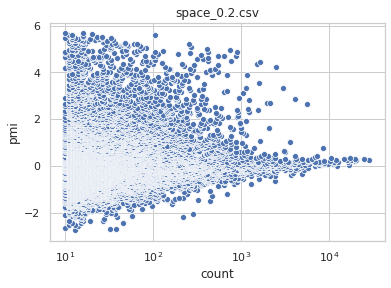

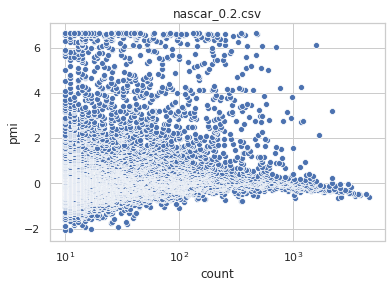

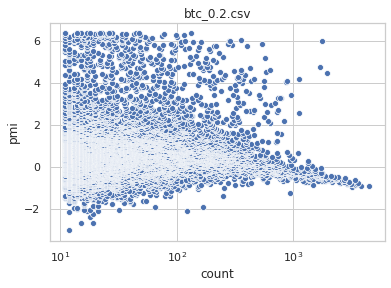

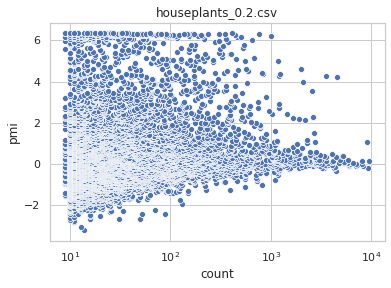

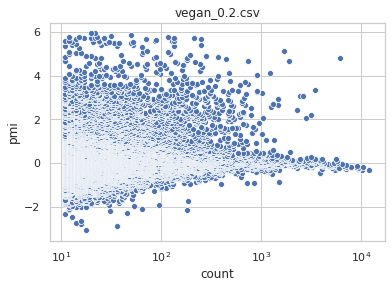

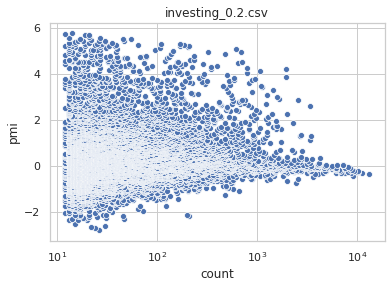

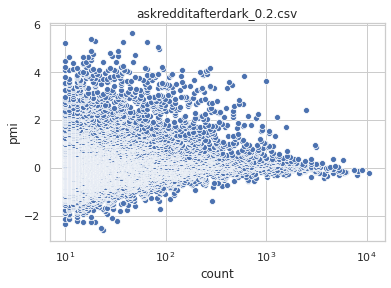

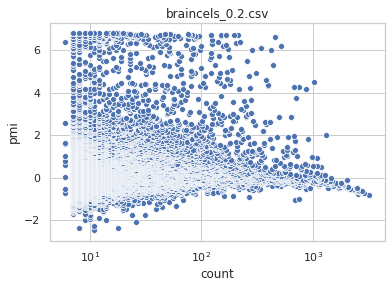

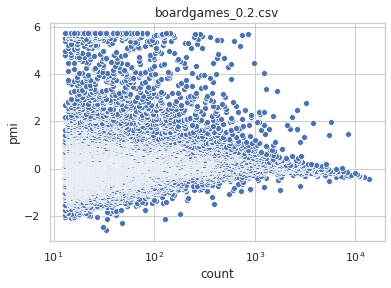

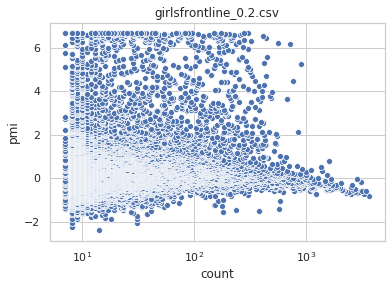

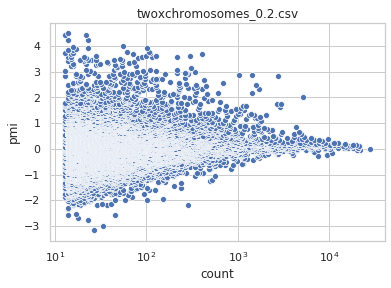

In [432]:
metric_vs_frequency('pmi', root + 'logs/pmi/', 10)

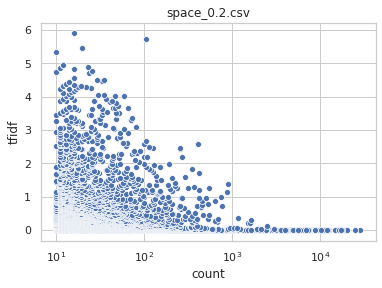

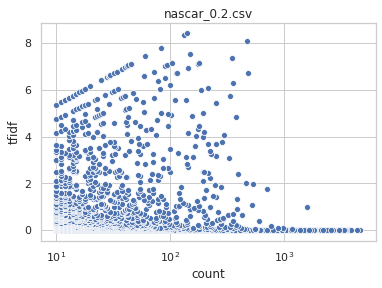

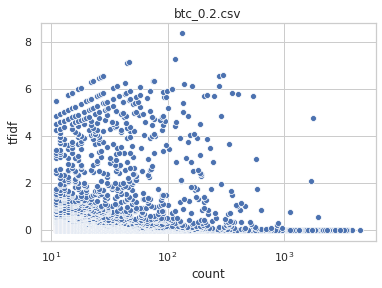

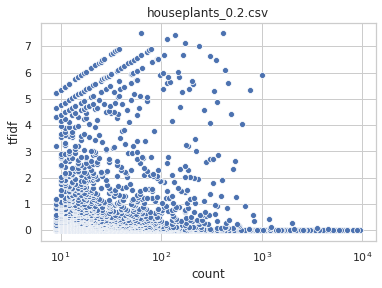

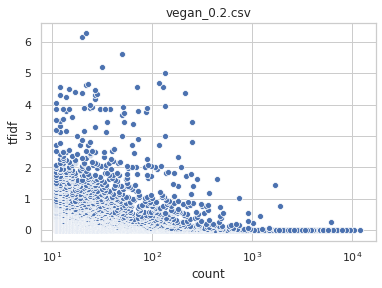

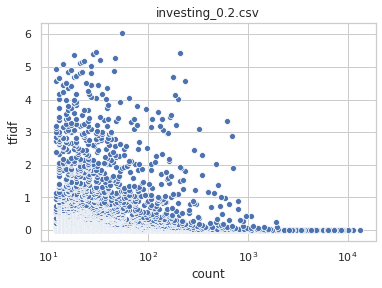

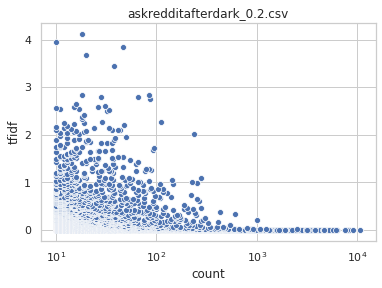

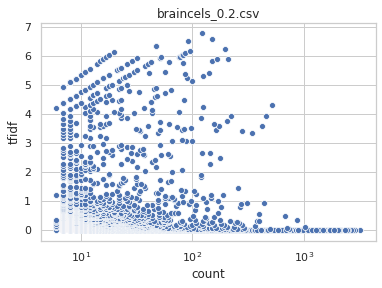

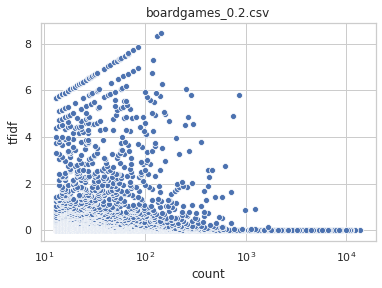

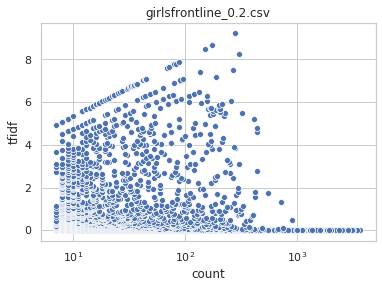

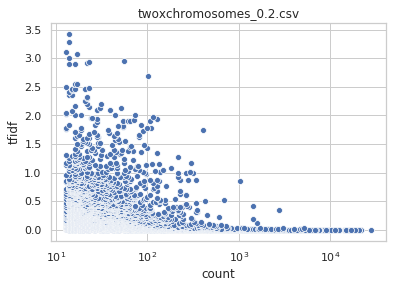

In [433]:
metric_vs_frequency('tfidf', root + 'logs/tfidf/', 10)

In [434]:
def single_metric_vs_frequency(sr_f, metric_name, path): 
    df = pd.read_csv(path + sr_f, engine='python')
    df = df[df['count'] > count_cut_off]
    p = sns.scatterplot(x='count', y=metric_name, data=df)
    p.figure.get_axes()[0].set_xscale('log')
    plt.title(sr_f)
    plt.show()

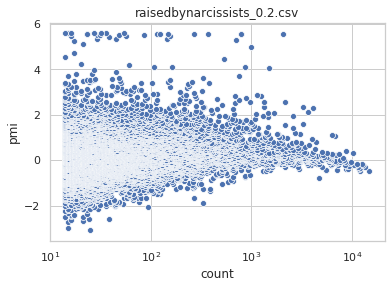

In [435]:
# Look at a single subreddit
single_metric_vs_frequency('raisedbynarcissists_0.2.csv', 'pmi', root + 'logs/pmi/')

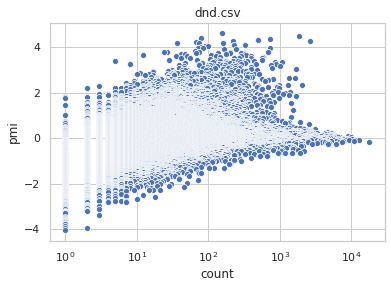

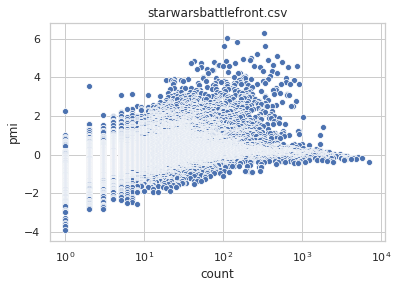

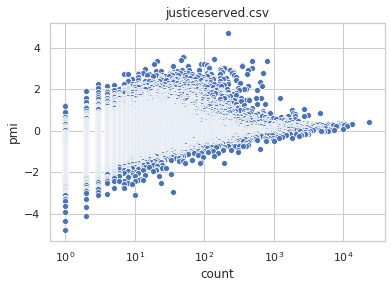

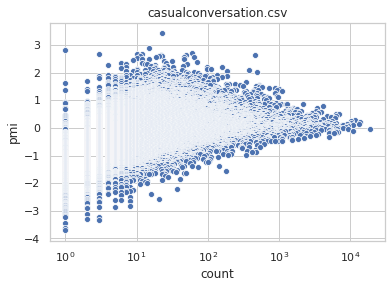

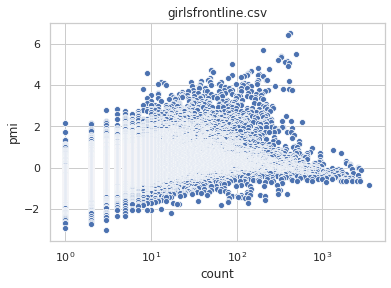

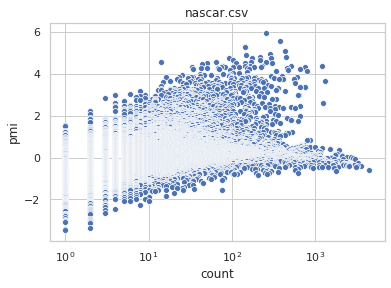

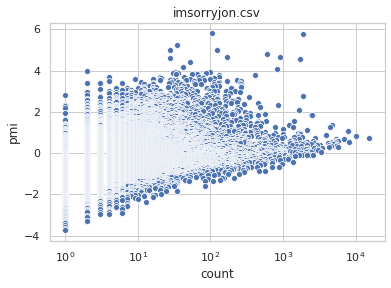

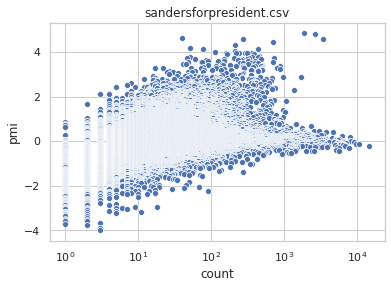

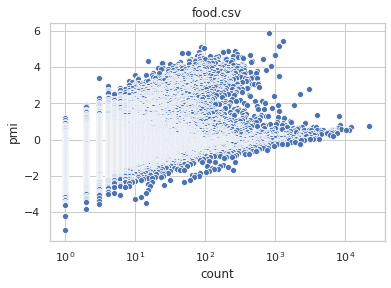

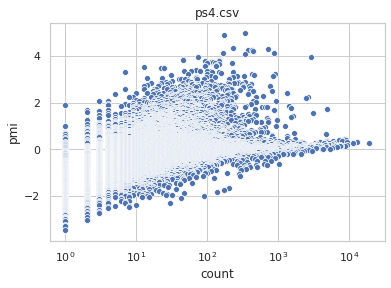

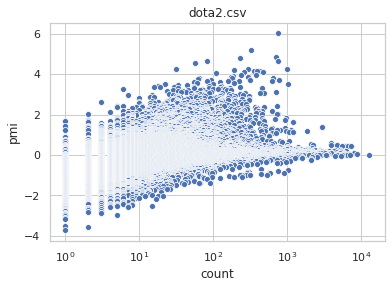

In [436]:
# sense pmi vs sense frequency
metric_vs_frequency('pmi', root + 'logs/finetuned_sense_pmi/', 10)

### Histogram of word choice values

In [12]:
def word_choice_hist(metric_name, path, n): 
    i = 0
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        df = pd.read_csv(path + f, engine='python')
        df = df[df['count'] > count_cut_off]
        p = sns.distplot(a=df[metric_name], kde=False)
        plt.yscale('log')
        plt.ylabel('# of words')
        plt.title(f)
        plt.show()
        i += 1
        if i > n: break

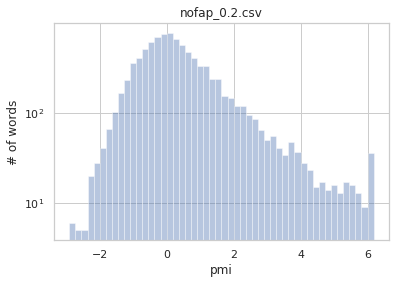

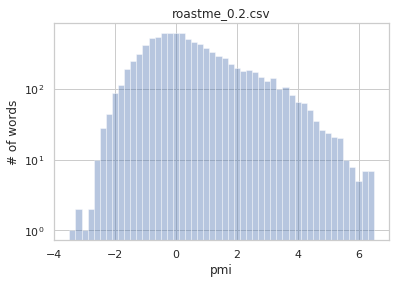

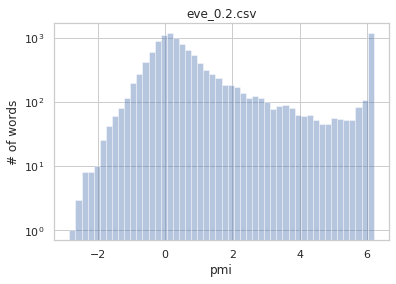

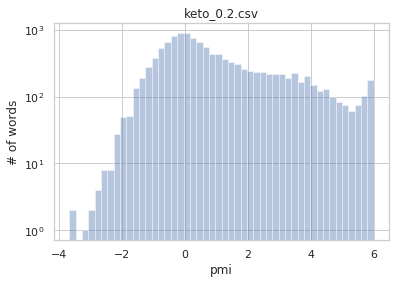

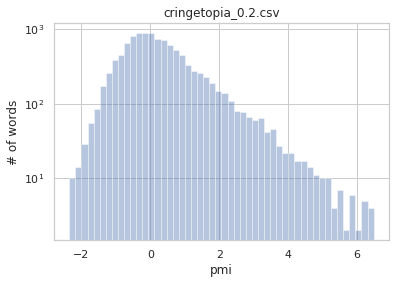

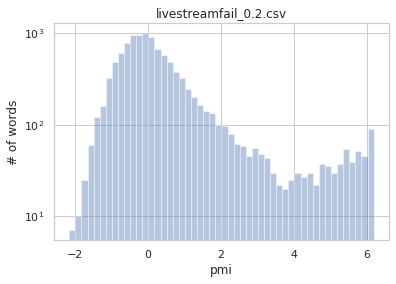

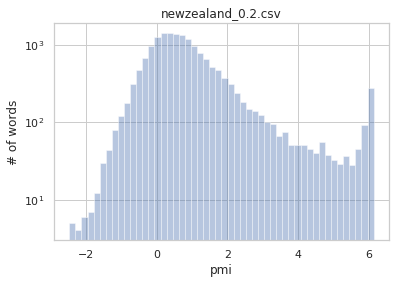

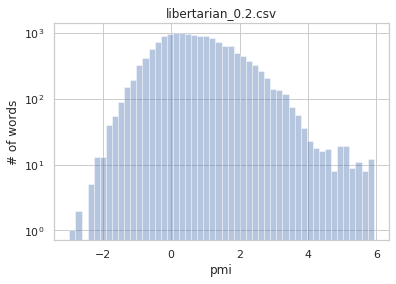

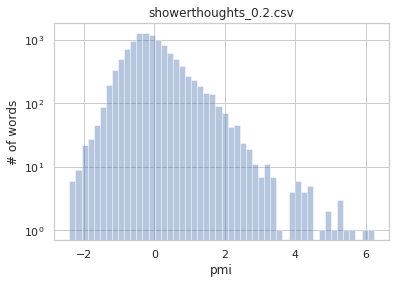

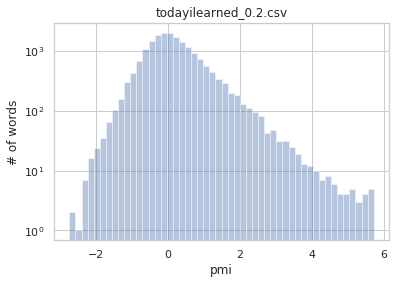

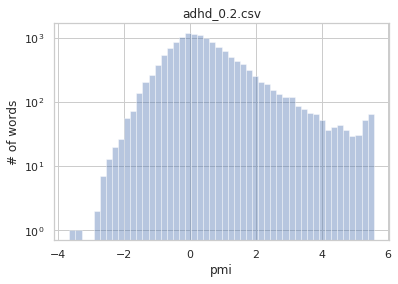

In [13]:
word_choice_hist('pmi', root+'/logs/pmi/', 10)

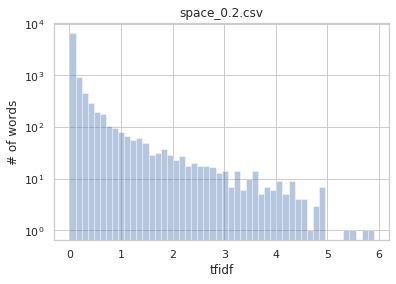

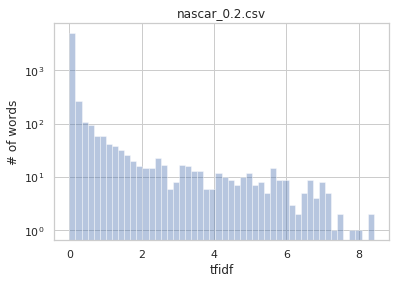

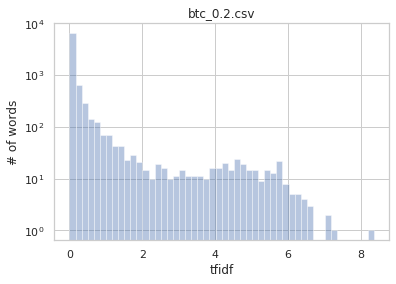

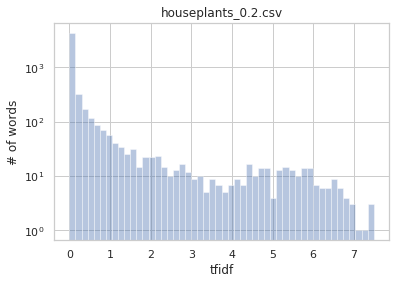

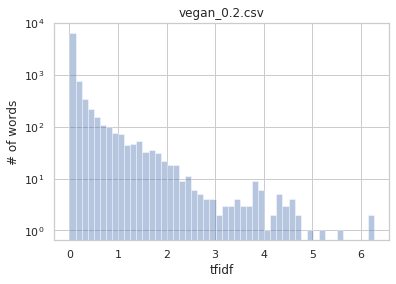

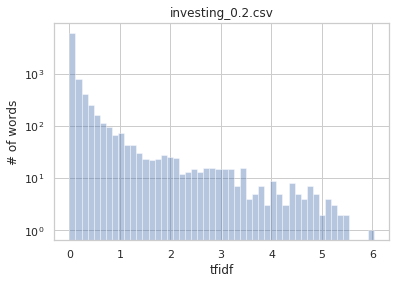

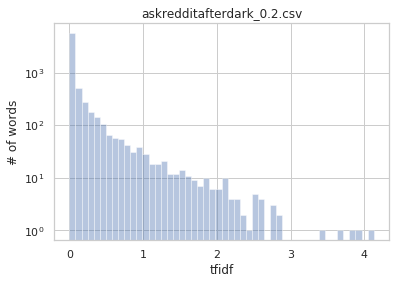

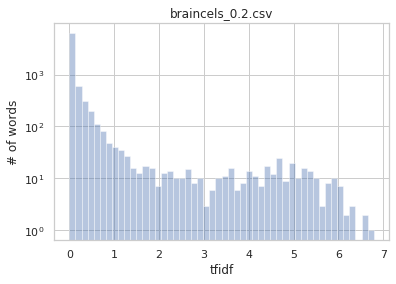

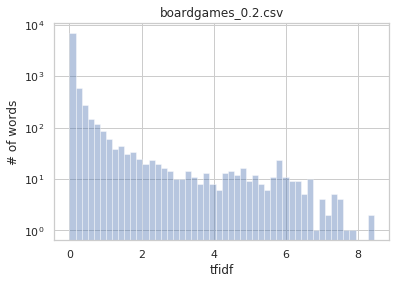

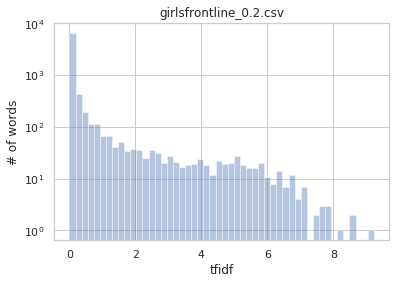

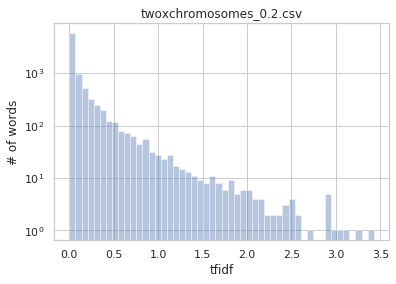

In [439]:
word_choice_hist('tfidf', root+'/logs/tfidf/', 10)

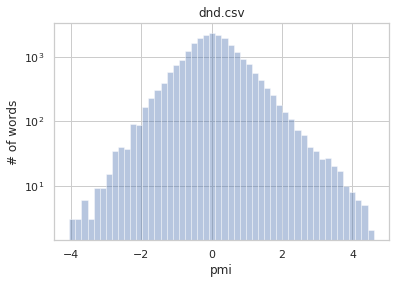

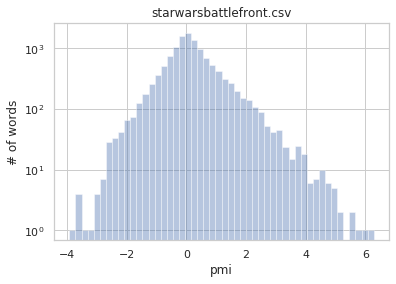

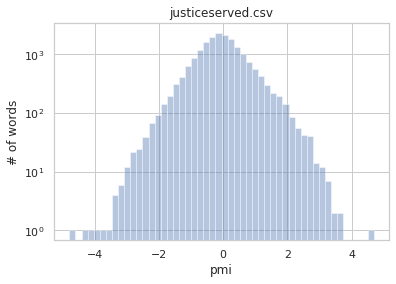

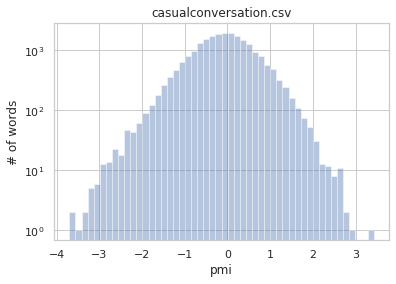

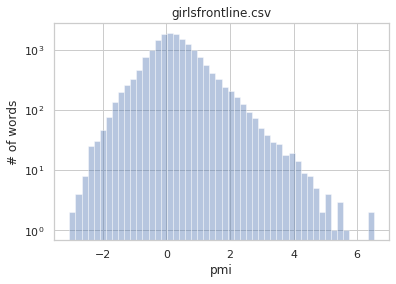

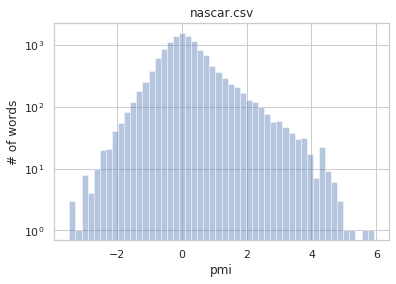

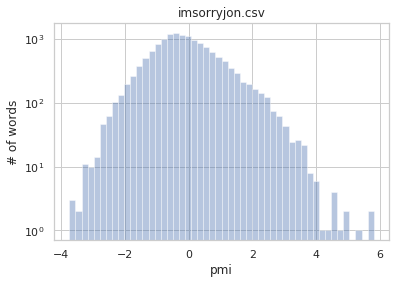

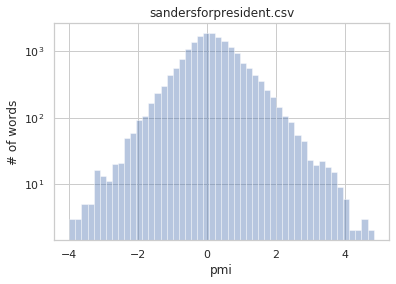

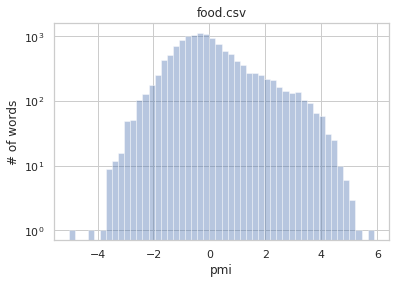

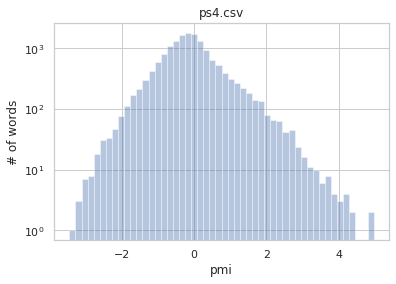

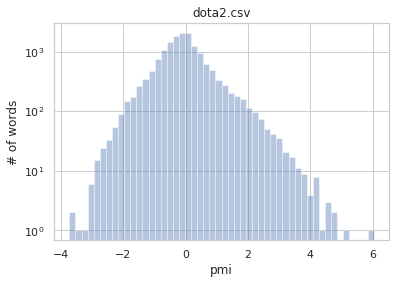

In [440]:
word_choice_hist('pmi', root+'/logs/finetuned_sense_pmi/', 10)

### Most and Least Sociolect-y

In [441]:
from collections import Counter

In [442]:
def most_and_least(metric_name, path, cut_off): 
    score_dict = Counter()
    suffix = '_0.2.csv'
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        subreddit = f.replace(suffix, '').replace('.csv', '')
        df = pd.read_csv(path + f, engine='python')
        notable_words = df[df['count'] > count_cut_off]
        num_words = len(notable_words)
        high_val_df = notable_words[notable_words[metric_name] > cut_off]
        num_high_val = len(high_val_df)
        score = num_high_val / float(num_words)
        score_dict[subreddit] = score
    mc = score_dict.most_common()
    print("TOP")
    print(mc[:10])
    print("BOTTOM")
    print(mc[-10:])

In [443]:
most_and_least('pmi', root + '/logs/pmi/', pmi_cut_off)

TOP
[('transcribersofreddit', 0.4714138993495378), ('pokemontrades', 0.17746552172781682), ('counting', 0.1337642963699652), ('indiaspeaks', 0.11540034350208554), ('jailbreak', 0.11403508771929824), ('yugioh', 0.10413158917238699), ('edh', 0.09911925066405704), ('mariomaker', 0.09863945578231292), ('fantasybaseball', 0.09691943127962085), ('rocketleagueexchange', 0.08559322033898305)]
BOTTOM
[('confessions', 0.0), ('relationships', 0.0), ('gameofthrones', 0.0), ('adviceanimals', 0.0), ('askreddit', 0.0), ('blackpeopletwitter', 0.0), ('askwomen', 0.0), ('confession', 0.0), ('worldnews', 0.0), ('trashy', 0.0)]


In [444]:
most_and_least('max_pmi', root + '/logs/ft_max_sense_pmi/', sensepmi_cut_off)

TOP
[('transcribersofreddit', 0.18955904713634059), ('fakecollegefootball', 0.1793103448275862), ('counting', 0.16052060737527116), ('truefmk', 0.13713405238828968), ('sub4sub', 0.12087912087912088), ('market76', 0.11980609418282548), ('massivecock', 0.11067809820732658), ('rocketleagueexchange', 0.10429447852760736), ('fantasybaseball', 0.10366624525916561), ('jobuds', 0.09908814589665653)]
BOTTOM
[('offmychest', 0.0002714440825190011), ('insanepeoplefacebook', 0.0002333177788147457), ('pics', 0.00021915406530791147), ('casualconversation', 0.00021235931195582927), ('todayilearned', 0.00017812611328820805), ('funny', 0.0), ('news', 0.0), ('blackpeopletwitter', 0.0), ('nostupidquestions', 0.0), ('askreddit', 0.0)]


In [445]:
from scipy.stats import spearmanr, pearsonr

SpearmanrResult(correlation=0.7706780691872941, pvalue=2.010706214086197e-94)
(0.5056978224377111, 3.8599580150807507e-32)


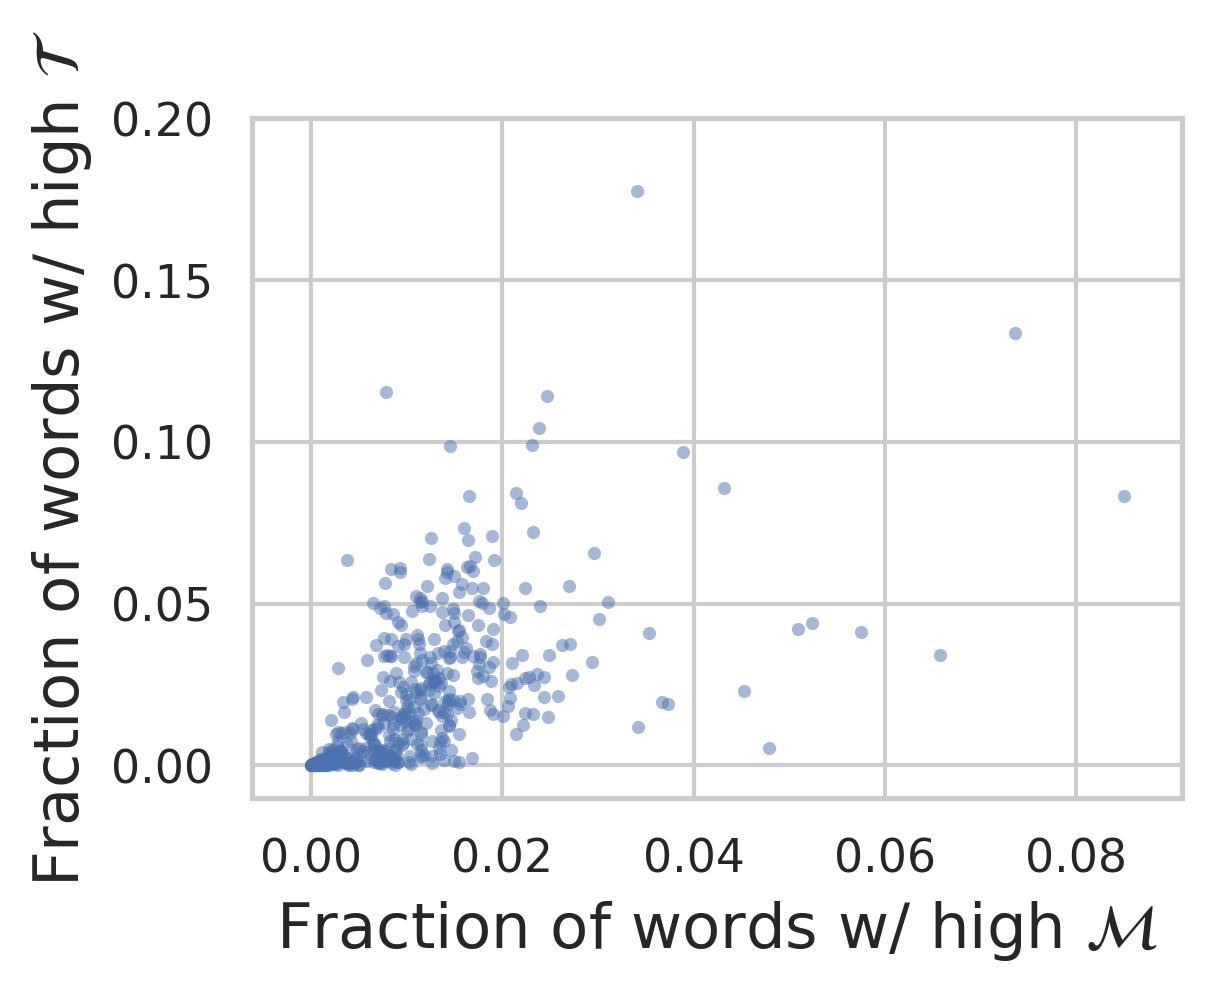

In [479]:
def get_fraction_correlation(): 
    y = []
    x = []
    for f in os.listdir(root + '/logs/ft_max_sense_pmi/'): 
        sr = f.replace('.csv', '')
        sense_scores = defaultdict(float)
        vocab_size = 0
        type_count = 0
        sense_count = 0
        with open(root + '/logs/ft_max_sense_pmi/' + f, 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['max_pmi'])
                sense_scores[w] = score
        with open(root + '/logs/pmi/' + sr + '_0.2.csv', 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['pmi'])
                vocab_size += 1
                if score > pmi_cut_off:  
                    type_count += 1
                if sense_scores[w] > sensepmi_cut_off: 
                    sense_count += 1
        y.append(type_count / float(vocab_size))
        x.append(sense_count / float(vocab_size))
    print(spearmanr(x, y))
    print(pearsonr(x, y))
    plt.figure(figsize=(4, 3), dpi=300)
    plt.scatter(x, y, alpha=0.5, marker='o', linewidths=0.0, s=10)
    plt.ylabel("Fraction of words w/ high $\mathcal{T}$", fontsize=15)
    plt.ylim((-0.01, 0.2))
    plt.xlabel("Fraction of words w/ high $\mathcal{M}$", fontsize=15)
    plt.show()
get_fraction_correlation()

### Size of community vs word choice

In [14]:
def user_sense_type_plot(commentor_path, sense_cutoff, type_cutoff, xlabel, 
                         xlog=True, xlim=None, ylim=None, turnoffy=False): 
    '''
    Combining type and finetuned max sense PMI as the y-axis into one plot 
    '''
    sr_ncoms = pd.read_csv(commentor_path, engine='python').set_index('subreddit').T.to_dict('list')
    y = []
    x = []
    for f in os.listdir(root + '/logs/ft_max_sense_pmi/'): 
        sr = f.replace('.csv', '')
        sense_scores = defaultdict(float)
        vocab_size = 0
        sociolect_count = 0
        with open(root + '/logs/ft_max_sense_pmi/' + f, 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['max_pmi'])
                sense_scores[w] = score
        with open(root + '/logs/pmi/' + sr + '_0.2.csv', 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['pmi'])
                vocab_size += 1
                if score > type_cutoff or sense_scores[w] > sense_cutoff:  
                    sociolect_count += 1
        y.append(sociolect_count / float(vocab_size))
        x.append(sr_ncoms[sr][0])
    plt.figure(figsize=(4, 3), dpi=300)
    plt.scatter(x, y, alpha=0.5, marker='o', linewidths=0.0, s=10)
    if xlog: 
        plt.xscale('log')
    if xlim: 
        plt.xlim(xlim)
    if ylim: 
        plt.ylim(ylim)
    plt.xlabel(xlabel, fontsize=25)
    if turnoffy: 
        plt.tick_params(
            axis='y',          
            which='both',      
            left=False,      
            right=False,         
            labelleft=False) 
    else: 
        plt.yticks(fontsize=15)
        plt.ylabel(r'$\mathcal{F}$', fontsize=30)
    plt.xticks(fontsize=15)
    plt.show()

In [15]:
def community_word_choice(commentor_path, metric_name, path, cut_off, xlabel, scatter=False, 
                               xlog=True, xlim=None, ylim=None): 
    sr_ncoms = pd.read_csv(commentor_path, engine='python').set_index('subreddit').T.to_dict('list')
    suffix = '_0.2.csv'
    y = []
    x = []
    srs = []
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        subreddit = f.replace(suffix, '').replace('.csv', '')
        df = pd.read_csv(path + f, engine='python')
        notable_words = df[df['count'] > count_cut_off]
        num_words = len(notable_words)
        high_val_df = notable_words[notable_words[metric_name] > cut_off]
        num_high_val = len(high_val_df)
        score = num_high_val / float(num_words)
        y.append(score)
        x.append(sr_ncoms[subreddit][0])
        srs.append(subreddit)
    if scatter == True: 
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, alpha=0.5, marker='.')
        if xlog: 
            plt.xscale('log')
    else: 
        if xlog: 
            x = np.log10(x)
        g = sns.jointplot(x, y, kind='hex')
    if xlim: 
        plt.xlim(xlim)
    if ylim: 
        plt.ylim(ylim)
    plt.ylabel(metric_name + ' > ' + str(cut_off) + ' / total words')
    plt.xlabel(xlabel)
    plt.show()

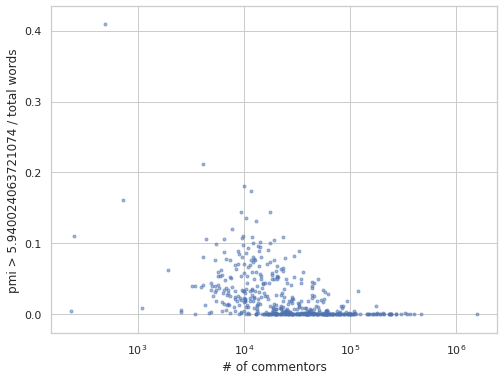

In [17]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', pmi_cut_off, 
                           '# of commentors', scatter=True)

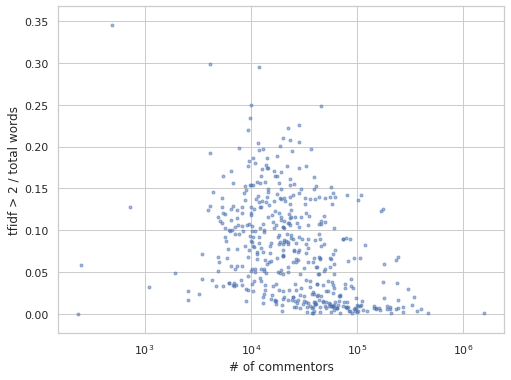

In [18]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', tfidf_cut_off, 
                           '# of commentors', scatter=True)

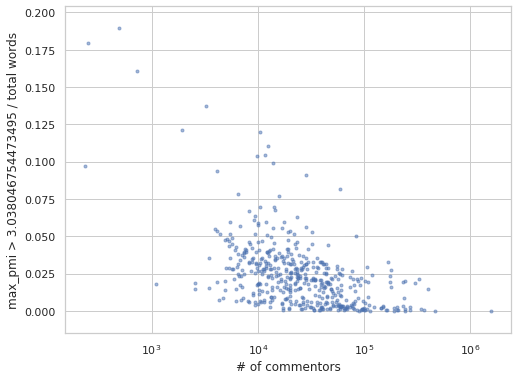

In [451]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
community_word_choice(commentor_path, 'max_pmi', root + '/logs/ft_max_sense_pmi/', sensepmi_cut_off, 
                           '# of commentors', scatter=True)

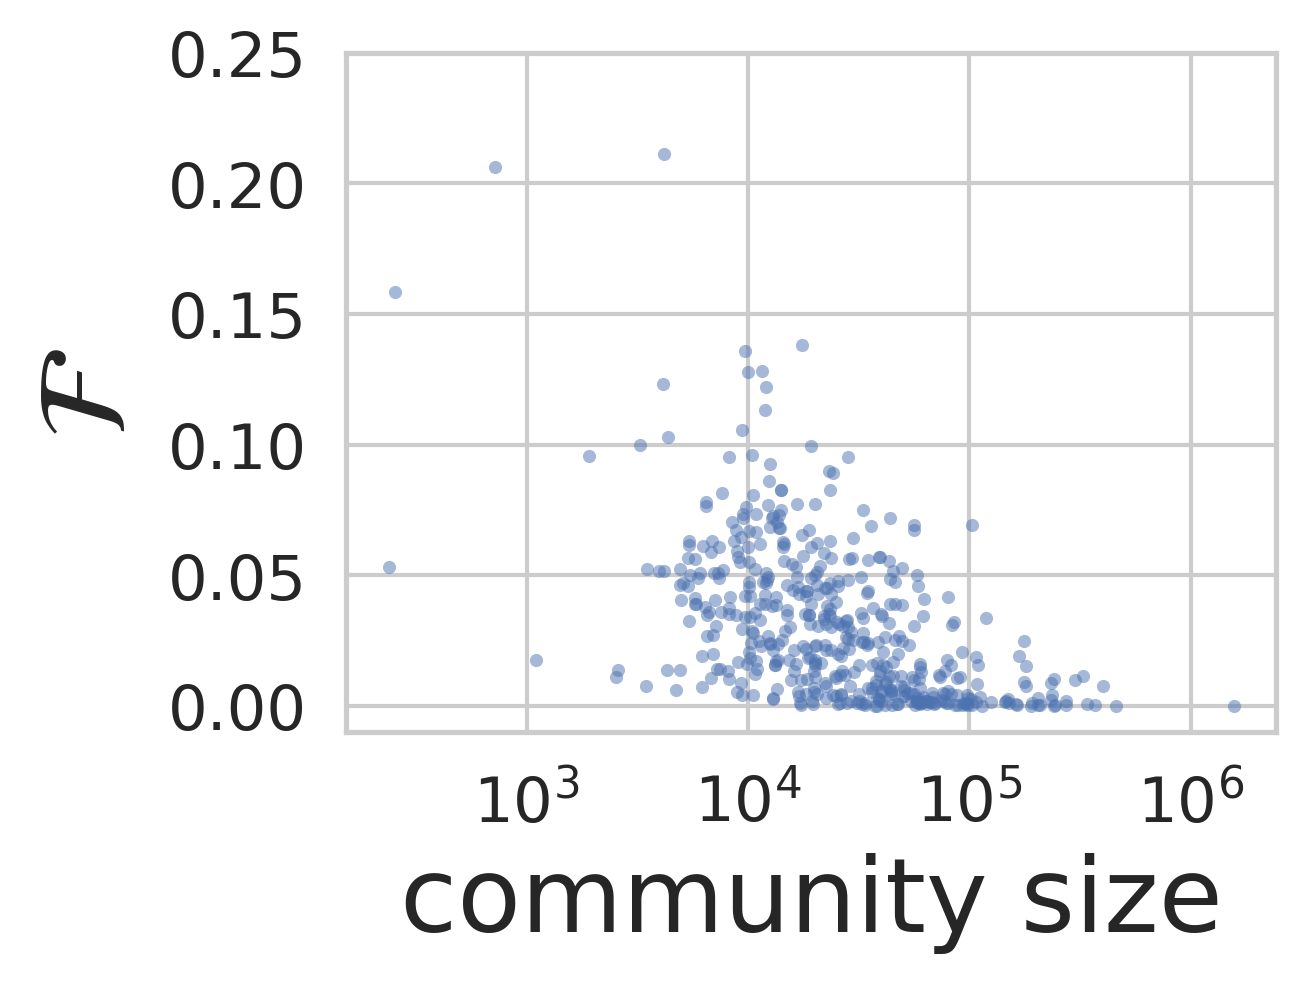

In [480]:
commentor_path = root + 'logs/commentor_counts/part-00000-64b1d705-9cf8-4a54-9c4d-598e5bf9085f-c000.csv'
user_sense_type_plot(commentor_path, sensepmi_cut_off, pmi_cut_off, 'community size', ylim=(-0.01, 0.25))

### User activity vs word choice

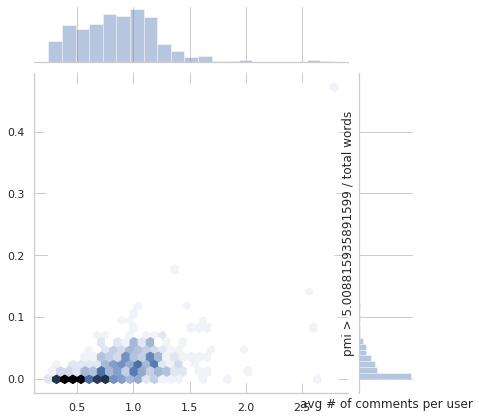

In [453]:
commentor_path = root + 'logs/commentor_activity'
community_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'avg # of comments per user')

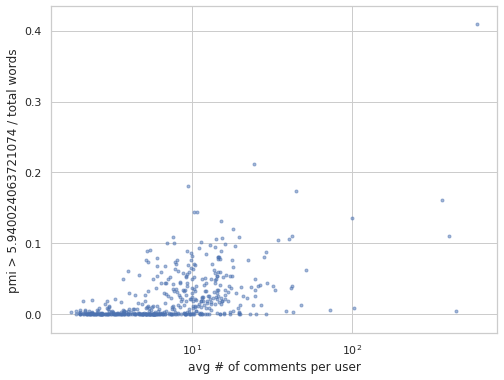

In [20]:
commentor_path = root + 'logs/commentor_activity'
community_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'avg # of comments per user', scatter=True)

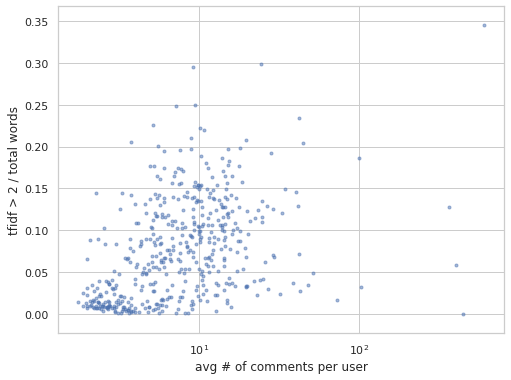

In [21]:
commentor_path = root + 'logs/commentor_activity'
community_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'avg # of comments per user', scatter=True)

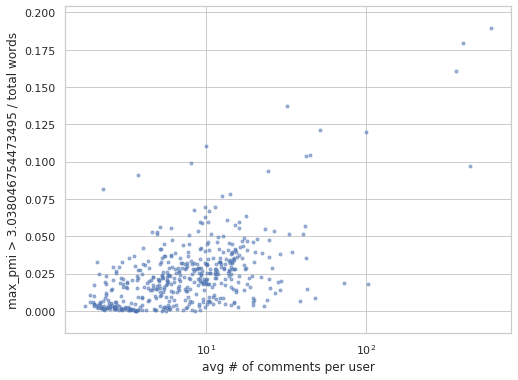

In [456]:
commentor_path = root + 'logs/commentor_activity'
community_word_choice(commentor_path, 'max_pmi', root + '/logs/ft_max_sense_pmi/', \
                           sensepmi_cut_off,  'avg # of comments per user', scatter=True)

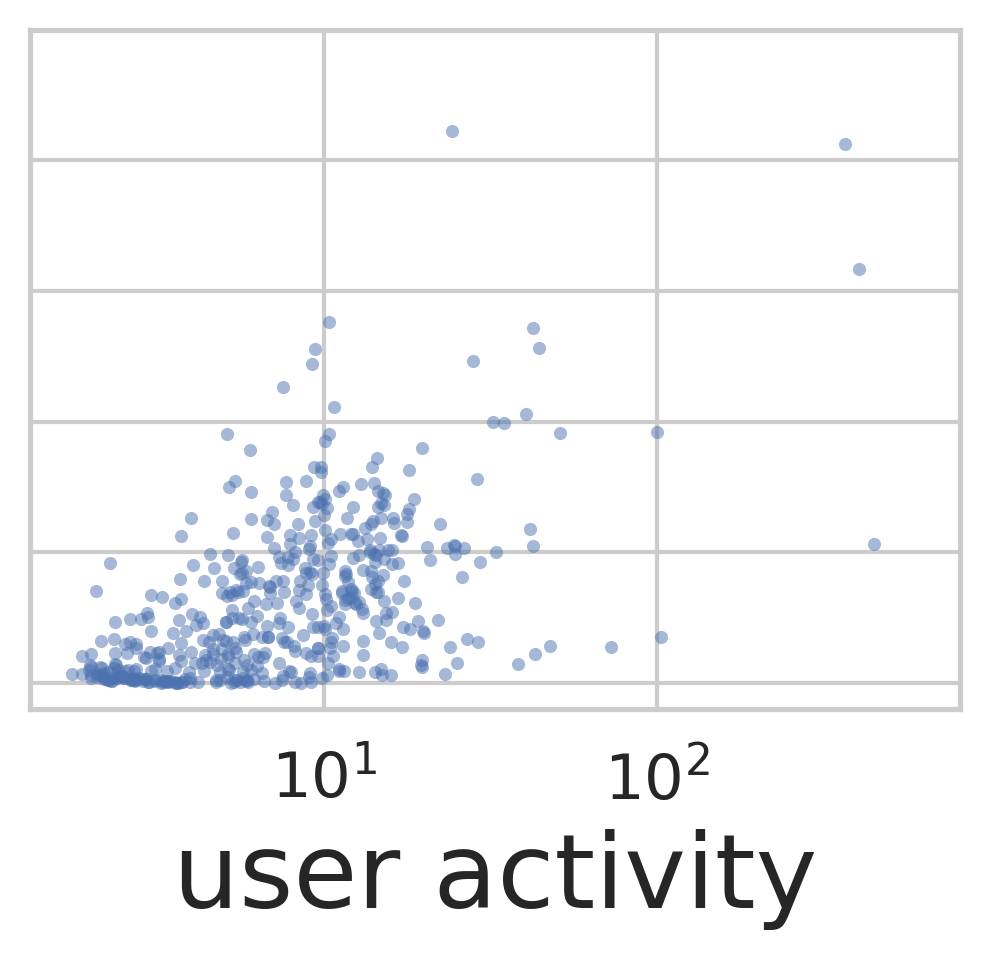

In [481]:
commentor_path = root + 'logs/commentor_activity'
user_sense_type_plot(commentor_path, sensepmi_cut_off, pmi_cut_off, 'user activity', turnoffy=True, ylim=(-0.01, 0.25))

### User loyalty vs word choice

In [23]:
threshold = 50

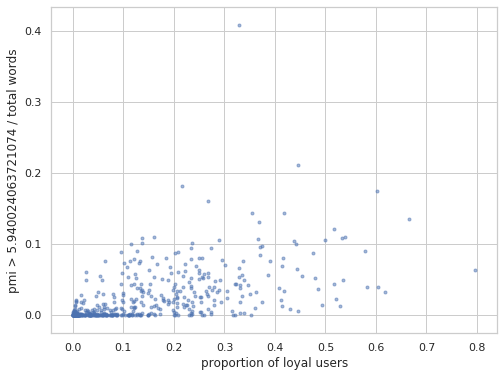

In [24]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'proportion of loyal users', scatter=True, xlog=False)

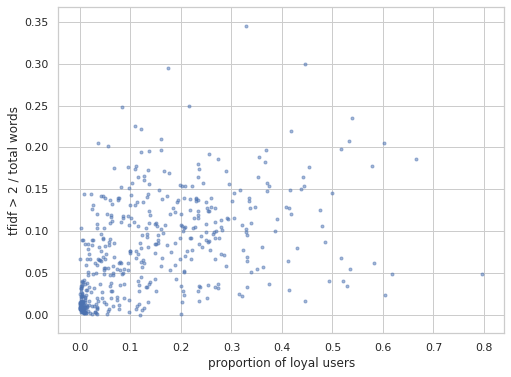

In [25]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'proportion of loyal users', scatter=True, xlog=False)

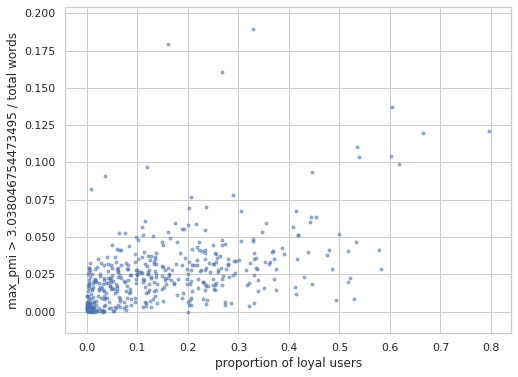

In [461]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
community_word_choice(commentor_path, 'max_pmi', root + '/logs/ft_max_sense_pmi/', \
                           sensepmi_cut_off, 'proportion of loyal users', scatter=True, xlog=False)

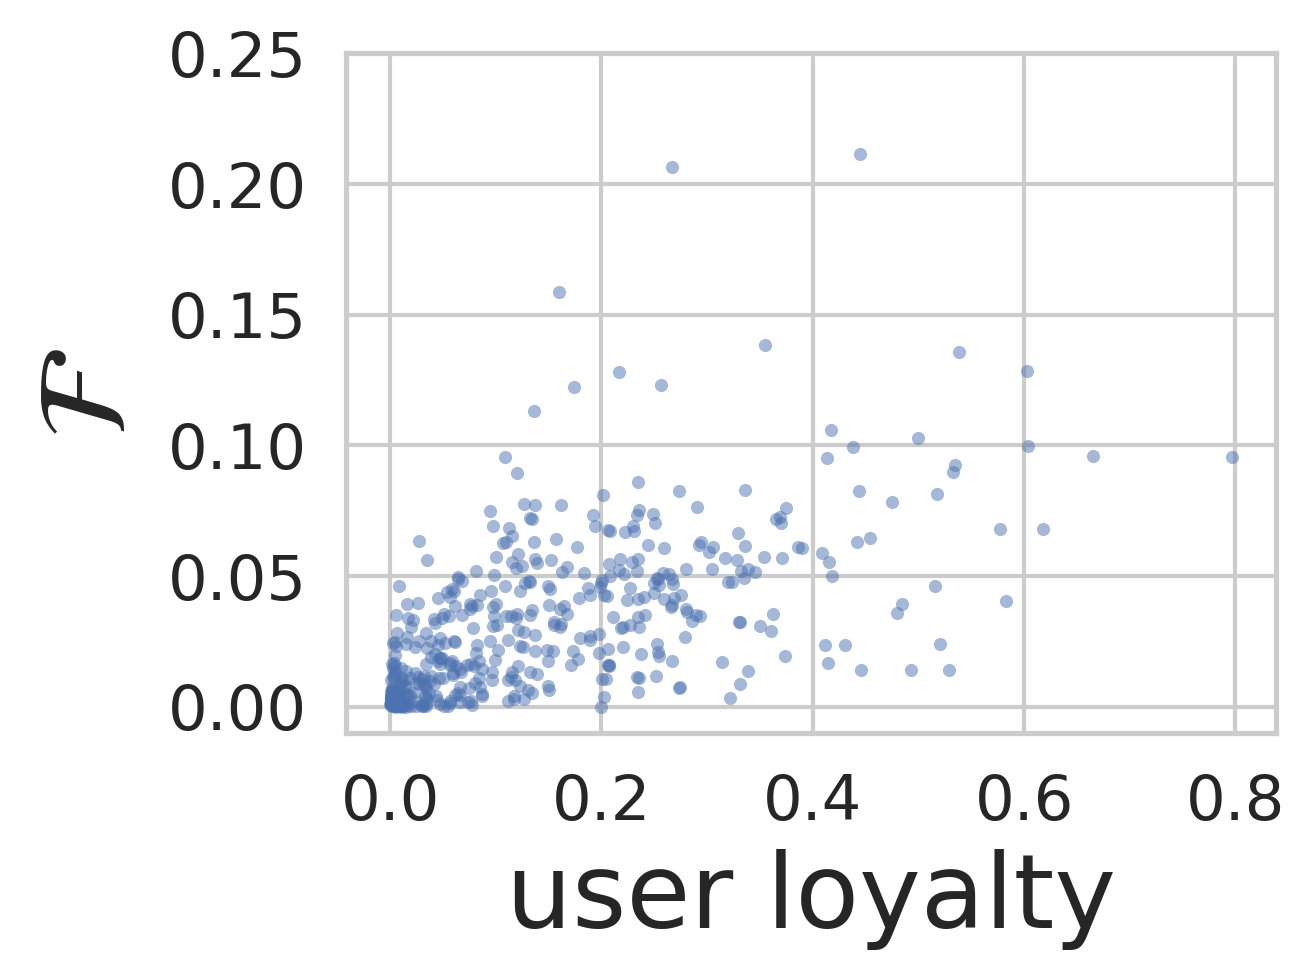

In [482]:
commentor_path = root + 'logs/commentor_loyalty_'+str(threshold)
user_sense_type_plot(commentor_path, sensepmi_cut_off, pmi_cut_off, 'user loyalty', xlog=False, ylim=(-0.01, 0.25))

### User density vs. word choice

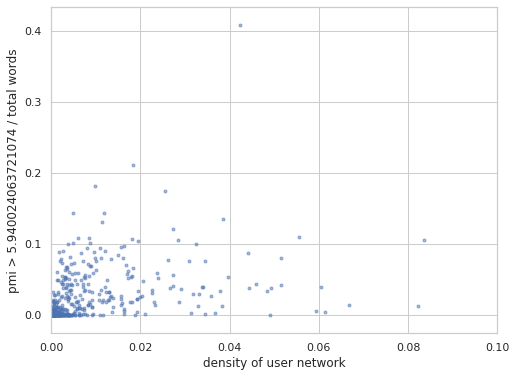

In [27]:
commentor_path = root + 'logs/commentor_density'
community_word_choice(commentor_path, 'pmi', root + '/logs/pmi/', \
                           pmi_cut_off, 'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))

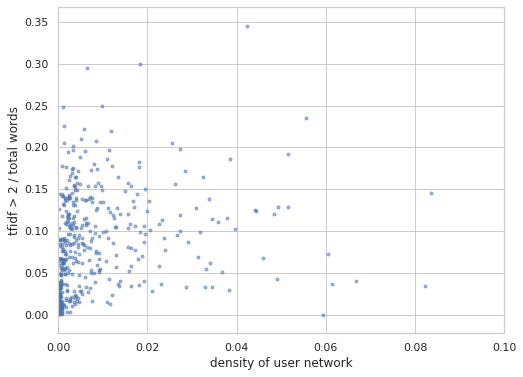

In [28]:
commentor_path = root + 'logs/commentor_density'
community_word_choice(commentor_path, 'tfidf', root + '/logs/tfidf/', \
                           tfidf_cut_off,  'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))

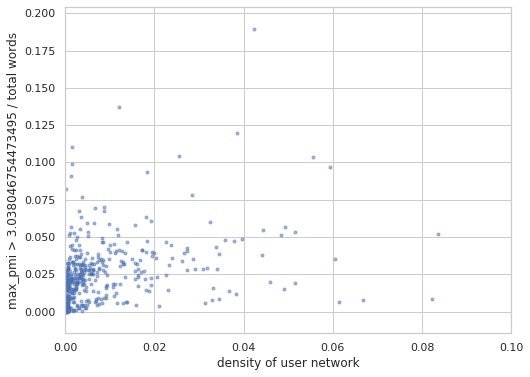

In [465]:
commentor_path = root + 'logs/commentor_density'
community_word_choice(commentor_path, 'max_pmi', root + '/logs/ft_max_sense_pmi/', \
                           sensepmi_cut_off, 'density of user network', scatter=True, 
                           xlog=False, xlim=(0, 0.1))

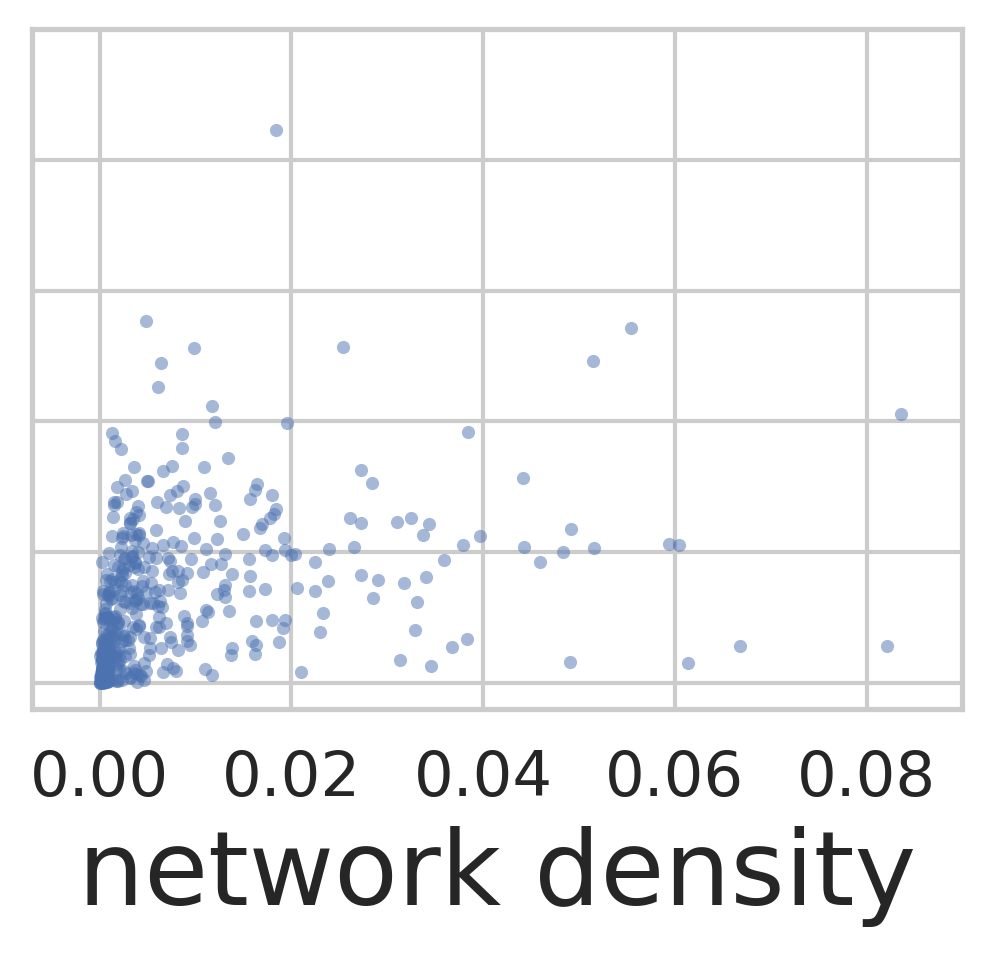

In [486]:
commentor_path = root + 'logs/commentor_density'
user_sense_type_plot(commentor_path, sensepmi_cut_off, pmi_cut_off, 'network density', 
                     xlim=(-0.007, 0.09), xlog=False, turnoffy=True, ylim=(-0.01, 0.25))

## Topics

In [467]:
from collections import defaultdict, Counter

In [468]:
topics = {}
with open('../data/subreddit_topics.txt', 'r') as infile:
    prefix = ''
    curr_title = ''
    for line in infile: 
        if line.startswith('*'): 
            prefix = line.replace('*', '').strip()
            curr_title = prefix
        if line.startswith('~'):
            curr_title = prefix + '_' + line.replace('~', '').strip()
        if line.startswith('/r/'): 
            subreddit = line.replace('/r/', '').strip().split()[0].lower()
            topics[subreddit] = curr_title

In [469]:
reddits = set()
non_english_reddits = set()
with open('../data/non_english_sr.txt', 'r') as inputfile: 
    for line in inputfile: 
        non_english_reddits.add(line.strip().lower())
with open('../data/subreddit_list.txt', 'r') as inputfile: 
    for line in inputfile: 
        sr = line.strip().lower()
        if sr not in non_english_reddits: 
            reddits.add(sr)
topic_counts = Counter()
for sr in reddits: 
    if sr in topics: 
        umbrella = topics[sr].split('_')[0]
        smaller_topic = topics[sr]
        topic = umbrella
        if umbrella in set(['Entertainment', 'Other', 'Lifestyle']): 
            topic = smaller_topic
        topic_counts[topic] += 1
topic_assignments = {}
for sr in reddits:
    if sr in topics: 
        if topic_counts[topics[sr]] >= 10: 
            topic_assignments[sr] = topics[sr]
        elif topic_counts[topics[sr].split('_')[0]] >= 10: 
            topic_assignments[sr] = topics[sr].split('_')[0]
        else: 
            topic_assignments[sr] = 'Other'
    else: 
        topic_assignments[sr] = 'Other'

In [470]:
with open(root + 'logs/topic_assignments.json', 'w') as outfile:
    json.dump(topic_assignments, outfile)

In [471]:
print(set(topics.values()))

{'Lifestyle_Self-Improvement', 'Other_Nostalgia/Time', 'Hobbies/Occupations_Guns/Combat', 'Educational_Medicine', 'Entertainment_General', 'Educational_Economics', 'Hobbies/Occupations_Design', 'Other_Cringe', 'Other_Free Stuff', 'Other_Nature', 'Other_Parodies', 'Hobbies/Occupations_General', 'Animals', 'General Content_Images', 'Entertainment_Sports', 'Educational_Anthropology', 'Entertainment_Internet/Apps', 'Lifestyle_Communities', 'Lifestyle_Food', 'Hobbies/Occupations_Automotive', 'Educational_Science', 'Other_SFWPorn Network', 'Discussion_AMA', 'Educational_History', 'Entertainment_Games', 'Other_Weird Feelings/Categorize Later', 'Educational_General', 'Educational_Psychology', 'Discussion_Question/Answer', 'Discussion_Stories', 'Lifestyle_Exercise/Health', 'Discussion_Advice', 'Educational_Law', 'Hobbies/Occupations_Planes', 'Entertainment_Movies', 'Discussion_General', 'Hobbies/Occupations_Tech Related', 'Hobbies/Occupations_Outdoors', 'Other_Mind blowing', 'Other_News/Politic

In [487]:
topic_remap = {'Hobbies/Occupations':'Hobbies/Occ.', 
               'Entertainment_Video games': 'Video Games', 
               'Entertainment_TV': 'TV', 
               'Other_Disgusting/Angering/Scary/Weird': 'DASW',
               'Other_Cringe': 'Cringe', 
               'Entertainment_Internet/Apps': 'Internet/Apps', 
               'Other_Geography': 'Geography',
               'Lifestyle_Relationships/Sex' : 'Relationships/Sex', 
               'Other': 'Other', 
               'Lifestyle_Technology' : 'Technology',
               'Entertainment_Sports' : 'Sports', 
               'Humor': 'Humor', 
               'Discussion': 'Discussion',
              }
def get_topic_df(metric_name, path, cut_off):
    d = {'scores' : [], 'subreddit': [], 'topic': []}
    for f in os.listdir(path): 
        if not f.endswith('.csv'): continue
        subreddit = f.replace('_0.2.csv', '').replace('.csv', '')
        df = pd.read_csv(path + f, engine='python')
        notable_words = df[df['count'] > count_cut_off]
        num_words = len(notable_words)
        high_val_df = notable_words[notable_words[metric_name] > cut_off]
        num_high_val = len(high_val_df)
        score = num_high_val / float(num_words)
        d['scores'].append(score)
        d['subreddit'].append(subreddit)
        d['topic'].append(topic_remap[topic_assignments[subreddit]])
    return pd.DataFrame(data=d)
def get_topic_df_combined(sense_cutoff, type_cutoff): 
    d = {'scores' : [], 'subreddit': [], 'topic': []}
    for f in os.listdir(root + '/logs/ft_max_sense_pmi/'): 
        sr = f.replace('.csv', '')
        sense_scores = defaultdict(float)
        vocab_size = 0
        sociolect_count = 0
        with open(root + '/logs/ft_max_sense_pmi/' + f, 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['max_pmi'])
                sense_scores[w] = score
        with open(root + '/logs/pmi/' + sr + '_0.2.csv', 'r') as infile:
            reader = csv.DictReader(infile)
            for row in reader: 
                w = row['word']
                score = float(row['pmi'])
                vocab_size += 1
                if score > type_cutoff or sense_scores[w] > sense_cutoff:  
                    sociolect_count += 1
        d['scores'].append(sociolect_count / float(vocab_size))
        d['subreddit'].append(sr)
        d['topic'].append(topic_remap[topic_assignments[sr]])
    return pd.DataFrame(data=d)

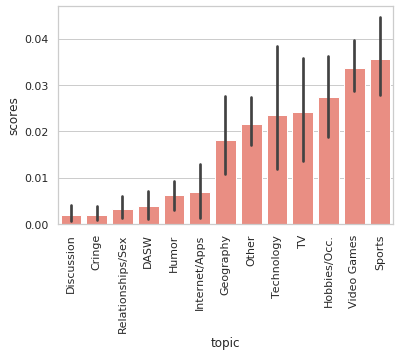

In [488]:
df = get_topic_df('pmi', root + '/logs/pmi/', pmi_cut_off)
result = df.groupby(["topic"])['scores'].aggregate(np.mean).reset_index().sort_values('scores')
sns.barplot(x="topic", y="scores", data=df, order=result['topic'], color='salmon')
plt.xticks(rotation=90)
plt.show()

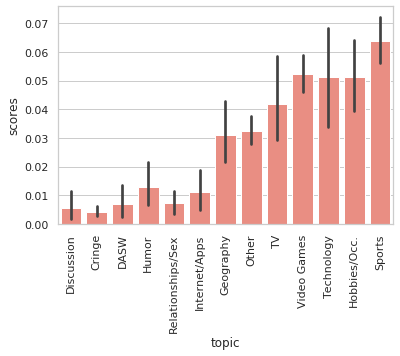

In [489]:
df = get_topic_df('tfidf', root + '/logs/tfidf/', tfidf_cut_off)
result = df.groupby(["topic"])['scores'].aggregate(np.median).reset_index().sort_values('scores')
sns.barplot(x="topic", y="scores", data=df, order=result['topic'], color='salmon')
plt.xticks(rotation=90)
plt.show()

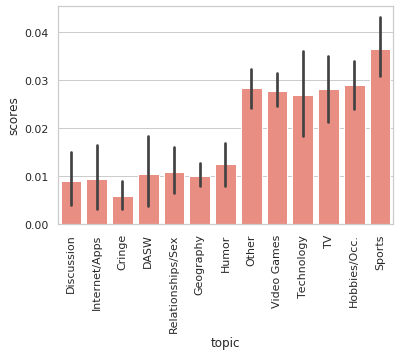

In [490]:
df = get_topic_df('max_pmi', root + '/logs/ft_max_sense_pmi/', sensepmi_cut_off)
result = df.groupby(["topic"])['scores'].aggregate(np.median).reset_index().sort_values('scores')
sns.barplot(x="topic", y="scores", data=df, order=result['topic'], color='salmon')
plt.xticks(rotation=90)
plt.show()

In [494]:
df = get_topic_df_combined(sensepmi_cut_off, pmi_cut_off)

In [505]:
df[df['topic'] == 'Discussion'].sort_values('scores')

,scores,subreddit,topic
293,0.000000,askreddit,Discussion
396,0.000133,offmychest,Discussion
373,0.000139,advice,Discussion
171,0.000198,nostupidquestions,Discussion
3,0.000209,casualconversation,Discussion
99,0.000329,tooafraidtoask,Discussion
406,0.000380,showerthoughts,Discussion
148,0.000509,confessions,Discussion
354,0.000612,ama,Discussion
253,0.000672,confession,Discussion


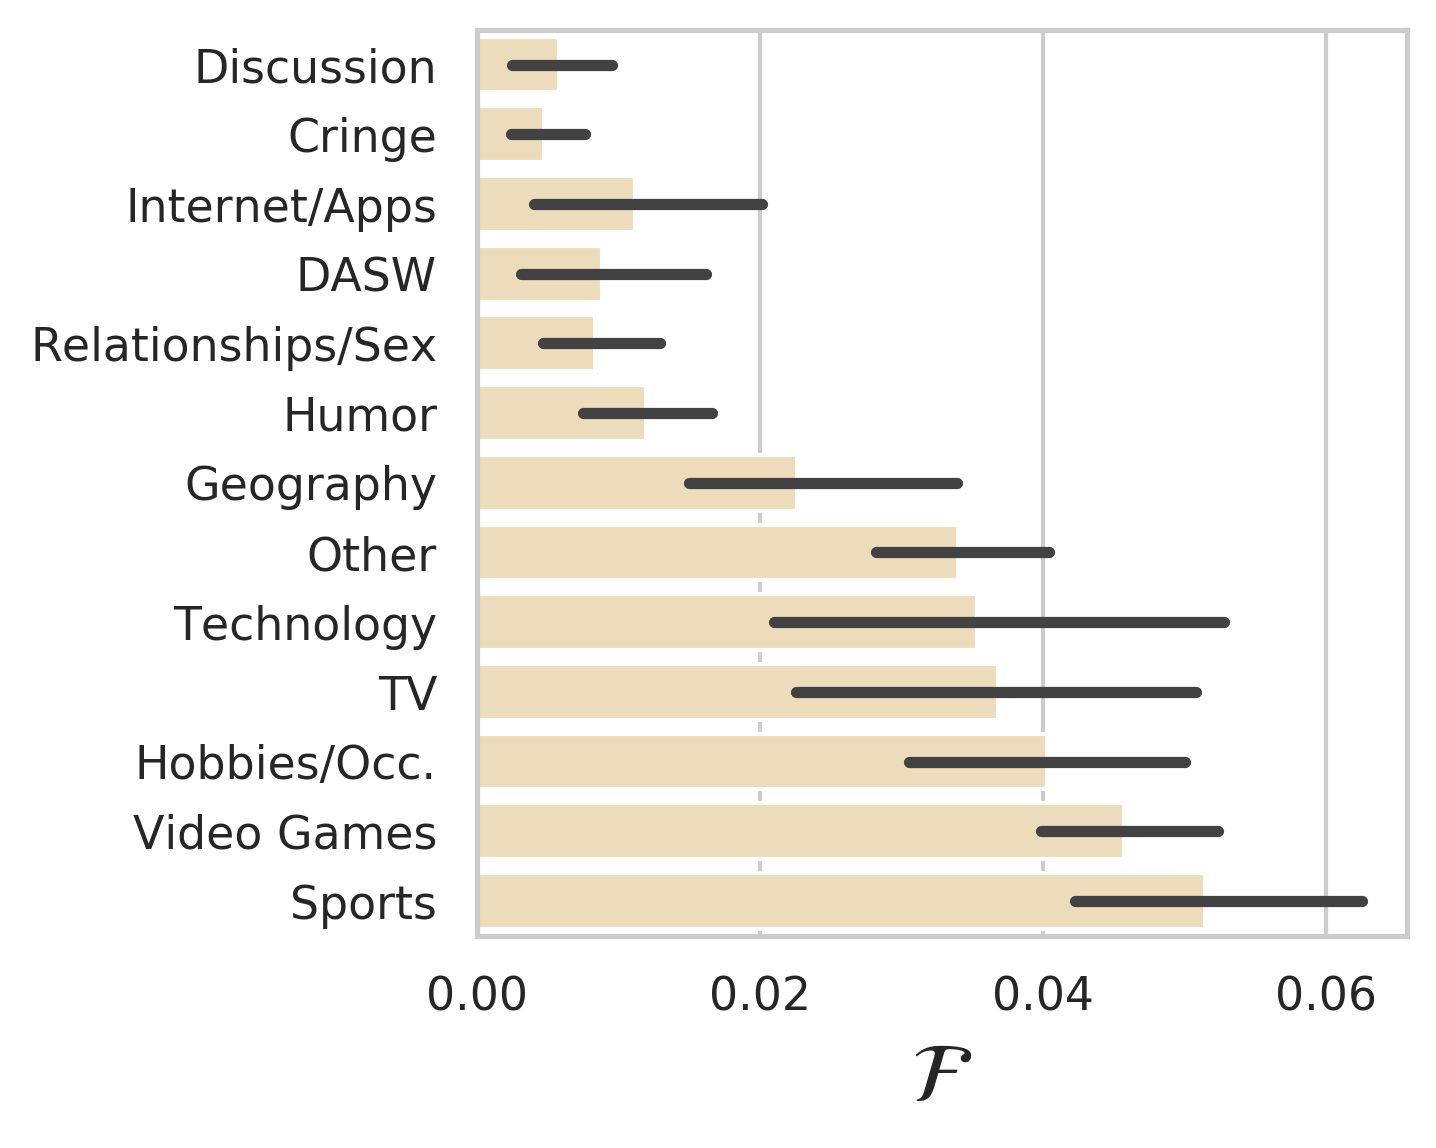

In [477]:
result = df.groupby(["topic"])['scores'].aggregate(np.median).reset_index().sort_values('scores')
plt.figure(figsize=(4, 4), dpi=300)
sns.barplot(x="scores", y="topic", data=df, order=result['topic'], color='wheat')
plt.xlabel(r'$\mathcal{F}$', fontsize=20)
plt.ylabel('')
plt.show()